# ADA final exam (Fall 2023)

This exam consists of 2 parts. Parts are independent from each other.

## Dataset


"Friends" is an American television sitcom that originally aired on NBC from September 22, 1994, to May 6, 2004. Created by David Crane and Marta Kauffman, the show gained immense popularity and has since become a classic in the world of television. The series is set in New York City and revolves around a group of six friends: Ross Geller (David Schwimmer), Rachel Green (Jennifer Aniston), Monica Geller (Courteney Cox), Chandler Bing (Matthew Perry), Joey Tribbiani (Matt LeBlanc), and Phoebe Buffay (Lisa Kudrow). The show explores their personal and professional lives as they navigate the ups and downs of relationships, careers, and the challenges of adulthood.

In this exam, we will use a dataset containing all the conversations that occurred over 10 seasons of Friends. We refer to each row in the dataset as an 'utterance." The data format of the dataset is as follows

- id: `<str>`, the index of the utterance in the format sAA_eBB_cCC_uDDD, where AA is the season number, BB is the episode number, CC is the scene/conversation number, and DDD is the number of the utterance in the scene (e.g. s01_e18_c05_u021).
- speaker: `<str>`, the speaker who made the utterance, e.g. Monica Geller
- conversation_id: `<str>`, the id of the first utterance in the conversation this utterance belongs. We assume conversations begin at the start of a new scene.
- reply_to: `<str>`, the id of the utterance to which this utterance replies. None if the utterance is the first in a conversation.
- text: `<str>`, the textual content of the utterance.


In [1]:
# First, let's import some required libraries!
import statsmodels.formula.api as smf
import pandas as pd
from collections import Counter
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import numpy as np


## Part 1: The one where you find the protagonist (60 pts)

A big debate among Friends fans is: who is the show's main character? In this task, your goal is to provide a data-driven answer to this question.


--- 

**1.1 —** Load the data from the jsonl file `exam1.jsonl` into a pandas dataframe. Then
 
 A. Calculate and display the number of distinct speakers in the dataframe.
 
 B. Calculate and display the number of conversations (see `conversation_id`).
 
 C. Remove all utterances from the dataframe where the `speaker` is "TRANSCRIPT_NOTE" or "#ALL#". Print the number of rows in the dataframe.
 
 D. Create additional columns corresponding to the season (`season`, e.g., season 1 should contain `s01`) and the episode (`episode`, e.g., episode 5 of season 4 should contain `s04_e05`) of each utterance. Print the season and the episode associated with utterance `s10_e18_c11_u019`.
 
 E. Create an additional column corresponding to the length of each utterance in terms of the number of characters (`length`). Print the length associated with utterance `s10_e18_c11_u019`.


In [20]:
# Import the JSONL file 
df = pd.read_json(path_or_buf="data/exam1.jsonl", lines=True)

In [28]:
#A.
distinct_speaker = df.speaker.nunique()
print("The number of unique speaker is {}.".format(distinct_speaker))

The number of unique speaker is 700.


In [27]:
#B.
number_of_conversations = df.conversation_id.nunique()
print("The number of conversations is {}.".format(number_of_conversations))

The number of conversations is 3107.


In [30]:
#C.
removed_speaker = ["TRANSCRIPT_NOTE", "#ALL#"]
df_v2 = df[~(df.speaker.isin(removed_speaker))]
print("The number of rows in the dataframe is {}.".format(df_v2.shape[0]))

The number of rows in the dataframe is 60985.


In [53]:
#D.
import re

lines = []
for tmp in list(df.id):
    line = [0,0]
    splitter_season = ["_e"]
    splitter_episode = ["_c"]
    pattern_season = '|'.join(map(re.escape, splitter_season))
    pattern_episode = '|'.join(map(re.escape, splitter_episode))
    line[0] = re.split(pattern_season, tmp)[0]
    line[1] = re.split(pattern_episode, tmp)[0]
    lines.append(line)

df_season_episode = pd.DataFrame(lines, columns=["season","episode"])
df_v3 = df_v2.join(df_season_episode)

In [57]:
verif = "s10_e18_c11_u019"
print("The season and episode of \"{}\" is:".format(verif))
df_v3.loc[df_v3["id"]==verif][["season","episode"]]

The season and episode of "s10_e18_c11_u019" is:


,season,episode
67370,s10,s10_e18


In [91]:
#E.
df_v4 = df_v3.assign(length=lambda x: [len(val) for val in x.text])
verif_value = df_v4.loc[df_v4["id"]==verif].length.values
print("The utterance length of \"{}\" is {}.".format(verif,verif_value))

The utterance length of "s10_e18_c11_u019" is [17].


**1.2** Next, you conduct some basic analyses:

 A. With `statsmodels`, fit a linear regression `length ~ C(season, Treatment(reference="s01"))`, where length is an integer and season is a categorical variable. Print the regression summary.
 
 B. /**Discuss:/** Considering the regression summary:
   - What does the intercept in this regression represent? 
   - What does the coefficient `C(season, Treatment(reference="s01"))[T.s09]` represent? 
   - Does the average utterance in season 9 contain significantly more characters than in season 1 at the 0.05 significance level? Justify with the regression summary **only**. 
   - Does the average utterance in season 10 contain significantly more characters than in season 1 at the 0.05 significance level? Justify with the regression summary  **only** .

 C. Argue visually (i.e., with a plot) that there are 6 main characters in the show.

In [95]:
#A.
mod = smf.ols(formula="length ~ C(season, Treatment(reference='s01'))", data=df_v4)
np.random.seed(42)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 length   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     8.058
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           4.96e-12
Time:                        15:55:39   Log-Likelihood:            -3.2981e+05
No. Observations:               60985   AIC:                         6.596e+05
Df Residuals:                   60975   BIC:                         6.597e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       51.0190      0.704     72.464      0.000      49.639      52.399
C(season, Treatment(reference='s01'))[T.s02]     2.2764      1.004      2.268      0.023       0.309       4.243
C(season, Treatment(reference='s01'))[T.s03]     1.1906      0.974      1.222      0.222      -0.718       3.100
C(season, Treatment(reference='s01'))[T.s04]     0.6674      0.980      0.681      0.496      -1.253       2.588
C(season, Treatment(reference='s01'))[T.s05]    -0.3185      0.984     -0.324      0.746      -2.247       1.610
C(season, Treatment(reference='s01'))[T.s06]     1.9612      0.974      2.013      0.044       0.052       3.871
C(season, Treatment(reference='s01'))[T.s07]     0.3712      0.979      0.379      0.705      -1.548       2.290
C(season, Treatment(reference='s01'))[T.s08]     1.1265      0.982      1.147      0.251      -0.799       3.052
C(season, Treatment(reference='s01'))[T.s09]     6.0889      0.979      6.222      0.000       4.171       8.007
C(season, Treatment(reference='s01'))[T.s10]    -0.8470      1.026     -0.825      0.409      -2.858       1.164
==============================================================================
Omnibus:                    39360.499   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           721113.209
Skew:                           2.832   Prob(JB):                         0.00
Kurtosis:                      18.865   Cond. No.                         11.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#B
- The intercept represent the mean outcome when all predictors are 0, so here it is 51.0190.
- `C(season, Treatment(reference="s01"))[T.s09]` means multiple things:
    - the predictor studied is `season`
    - it is a categorical value
    - `Treatment(reference="s01")` means `s01` is taken as the season reference
    - `[T.s09]`, the line studied here will give the result for the season 9, `s09`
- p_value for `C(season, Treatment(reference="s01"))[T.s09]` si far below 0.05 and the coefficient for season 9 is higher than the reference s01, so this assumption is true: the average utterance in season 9 contain significantly more characters than in season 1 at the 0.05 significance level
- No, this is wrong as the p_value is 0.409>0.05. So, it does not respect the significance level. This assumption is false: the average utterance in season 10 contain significantly more characters than in season 1 at the 0.05 significance level


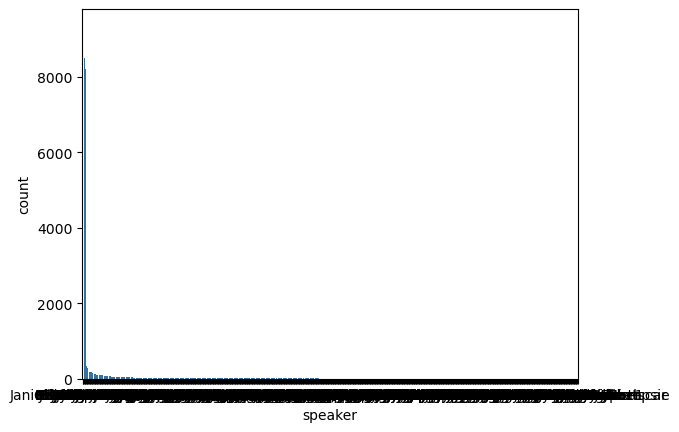

In [100]:
#C
value_count_speaker = df_v4.speaker.value_counts()
sns.barplot(value_count_speaker);

The previous plot is awful but it shows that very small characters have a utterance count way higher than the rest of other speakers. Let's dig in to that by just plotting the top 10 character in terms of utterance count.

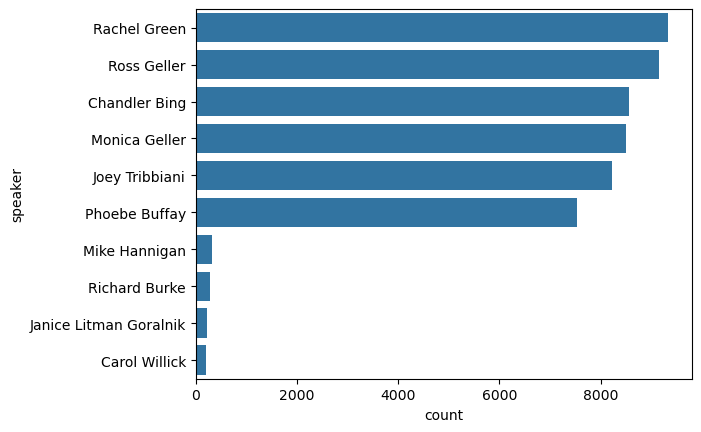

In [103]:
value_count_speaker = df_v4.speaker.value_counts().head(10)
sns.barplot(value_count_speaker, orient="h");

The above graph visually argues that 6 characters have more importance than the rest (by the above grah, one can understand that the other characters not present in the last graph speak less than Carol Willick).

--- 
**1.3 —** Using `networkx` 

A. Create a `MultiDiGraph` (directed graph with self loops and parallel edges) where:
- Each node $u$ is a character uniquely identified by the `speaker` field.
- There is an edge between nodes $u$ and $v$ if $u$ replied to $v$. If an utterance (a row in the dataframe) is said in reply to nobody, then it will not correspond to an edge. Each edge should contain two attributes. Each edge should have two attributes: `season` and `episode`.

B. Print the number of nodes and edges in your graph.

C. **/Discuss:/** Instead of using multi-edges, what would be another way in which you could capture the number of replies associated with each node pair?


In [ ]:
#A
G = nx.MultiDiGraph()

# Creates node attributes
node_list = df_v4.speaker.unique()
for tmp in node_list:
    G.add_node(tmp, speaker=tmp)

# Creates edge attributes
for i, edge in df_v4.iterrows():
    edge = dict(edge)
    if (i%10000==0 and i!=0):
        print("n_iter = {}".format(i))
    if (edge['reply-to']!=None):
        G.add_edge(str(edge['speaker']), str(df_v4.loc[df_v4.conversation_id==str(edge['reply-to'])].speaker), reply_to=edge['reply-to'])

#C

We could create a graph with nodes being the conversation_id and reply-to columns. The edges being their relations. The speakers associated to each edge is associated as attributes.

---
With the graph ready, you set out to investigate who is the true protagonist of Friends.

Ignore the graph you generated previously and instead use the graph provided in `exam2.graphml`. Note that this graph may be slightly different from what you generated, but treat it as the ground truth. We provide you with code to load the graph below.


In [134]:
import networkx as nx

G = nx.read_graphml("./data/exam2.graphml")

---

**1.4 —** Using the provided MultiDiGraph $G$:

A. Calculate the out-degree of each node (also known as out-degree centrality). Please do not use the `nx.out_degree_centrality` function here, as it normalizes the degree. (E.g., if a node has 5 outgoing edges, it should have out-degree 5 according to your code.)

B. Calculate the PageRank centrality of each node in $G$. Use the default parameters.

C. Print both centrality metrics calculated above for the six main characters of Friends.

D. **/Discuss:/** According to the metrics, who is the most important character in Friends?

In [169]:
#A.
# This returns the number of edges pointing out of each nodes
outdegree_dict = dict(G.out_degree())

In [162]:
#B.
pagerank_centrality = dict(nx.pagerank(G))

In [191]:
#C.
top6_characters = value_count_speaker.head(6).reset_index().speaker

top6_outdegree_dict={k: outdegree_dict.get(k,0) for k in top6_characters}
top6_centrality_dict={k: pagerank_centrality.get(k,0) for k in top6_characters}

print("Top 6 outdegree:")
print(top6_outdegree_dict)
print("\nTop 6 pagerank:")
print(top6_centrality_dict)

Top 6 outdegree:
{'Rachel Green': 8470, 'Ross Geller': 8234, 'Chandler Bing': 7702, 'Monica Geller': 7621, 'Joey Tribbiani': 7395, 'Phoebe Buffay': 6797}

Top 6 pagerank:
{'Rachel Green': 0.12684259753919158, 'Ross Geller': 0.12561115738701217, 'Chandler Bing': 0.1145352324808736, 'Monica Geller': 0.1134500759232524, 'Joey Tribbiani': 0.11283519639878972, 'Phoebe Buffay': 0.10206929426008514}


#D

Regardig the two above metrics, Rachel seems to be the most important character in Friends.

---

**1.5 —** **/True or false:/** Considering your answer in **1.4**, are the following statements true or false? Justify your answers. 

A. "If we inverted all  edges in the graph such that an edge $(u,v)$ becomes an edge $(v,u)$, the PageRank centrality would remain unchanged."

B. "If we removed all outgoing edges from Rachel Green, her PageRank centrality would remain unchanged."

C. "If a new node was introduced in the graph, with 1,000 outgoing edges towards each other node, but no incoming edge, it would have the highest PageRank centrality."


#A False, PageRank is based on the number of inlinks, so reversing the edges will have an impact on PageRank centrality

#B True, PageRank is based on inlinks so on its indegree, so this measure does not take care of the outgoing edge.

#C False, it is wrong as the pagerank centrality will be 0 a_ji is 0 for all edges as there are just outgoing edges.

---

**1.6 —** Next, you consider how these centrality metrics vary over the course of the seasons.

A. Calculate the PageRank and out-degree centrality of the 6 main characters per episode, i.e., for each episode, create a graph containing only the utterances of that episode and calculate the PageRank centrality for this new graph. Print the PageRank and the out-degree of Rachel Green for the first episode of the first season.

B. Considering the episode-level out-degree centrality of Phoebe Buffay in season 1 and in season 10, print the mean and the standard error of the mean.

C. Create a single plot with 10 inches of width and 4 inches of height. The plot should contain two panels, containing the average PageRank centrality per season of Rachel Green and Ross Geller (Panel A), and the average out-degree per season of Rachel Green and Ross Geller (Panel B). Show 95% confidence intervals in your plot (calculated over the episodes in each season).

D. **/Discuss:/** Does the plot support the hypothesis that Rachel was the show's protagonist in all 10 seasons? Explain why.

In [211]:
# A.
season = nx.get_edge_attributes(G, "season")
episode = nx.get_edge_attributes(G, "episode")
df = []
for u, v, k in G.edges:
    df.append(
    {   
        "speaker_1": u,
        "speaker_2": v,
        "season": season[(u,v,k)],
        "episode": episode[(u,v,k)]
    }
    )
df_G =pd.DataFrame(df)

In [239]:
# all subgraph for each episod stored in BIG_G
episode_list = df_G.episode.unique()
BIG_G = []
BIG_G.append([nx.from_pandas_edgelist(df_G.loc[df_G["episode"]==episode_list[k]], 'speaker_1', 'speaker_2', edge_attr=None, create_using = nx.MultiDiGraph()) for k in range(len(episode_list))])

In [257]:
top6_characters = value_count_speaker.head(6).reset_index().speaker
df_1 = []
df_2 = []
for tmp in range(len(episode_list)):
    outdegree_dict = dict(BIG_G[0][tmp].out_degree())
    pagerank_centrality = dict(nx.pagerank(BIG_G[0][tmp]))

    top6_outdegree_dict={k: outdegree_dict.get(k,0) for k in top6_characters}
    top6_centrality_dict={k: pagerank_centrality.get(k,0) for k in top6_characters}

    season = episode_list[tmp].split("_e")[0]

    for k,v in top6_outdegree_dict.items():
        df_1.append(
        {   
            "season": season,
            "episode": episode_list[tmp],
            "speaker": k,
            "outdegree": v
        }
        )

    for k,v in top6_centrality_dict.items():
        df_2.append(
        {   
            "season": season,
            "episode": episode_list[tmp],
            "speaker": k,
            "pagerank": v
        }
        )
df_1 = pd.DataFrame(df_1)
df_2 = pd.DataFrame(df_2)

df_centrality_all_episodes =pd.merge(df_1, df_2, how="inner", on=["season", "episode", "speaker"])

In [258]:
verif_final = "s01_e01"

print("Below the results for outdegree and pagerank centrality of Rachel Green in the {}.".format(verif_final))
df_centrality_all_episodes.loc[(df_centrality_all_episodes.speaker=="Rachel Green")&(df_centrality_all_episodes.episode==verif_final)]

Below the results for outdegree and pagerank centrality of Rachel Green in the s01_e01.


,season,episode,speaker,outdegree,pagerank
0,s01,s01_e01,Rachel Green,43,0.153122


In [259]:
#B

print("Below the outdegree and pagerank mean and sem of Phoebe Buffay in season 1")
df_centrality_all_episodes.loc[(df_centrality_all_episodes.speaker=="Phoebe Buffay")&(df_centrality_all_episodes.season=="s01")][["outdegree","pagerank"]].agg(["mean","sem"])

Below the outdegree and pagerank mean and sem of Phoebe Buffay in season 1


,outdegree,pagerank
mean,23.333333,0.104929
sem,2.200681,0.008984


In [260]:
print("Below the outdegree and pagerank mean and sem of Phoebe Buffay in season 10")
df_centrality_all_episodes.loc[(df_centrality_all_episodes.speaker=="Phoebe Buffay")&(df_centrality_all_episodes.season=="s10")][["outdegree","pagerank"]].agg(["mean","sem"])

Below the outdegree and pagerank mean and sem of Phoebe Buffay in season 10


,outdegree,pagerank
mean,36.944444,0.130547
sem,2.809266,0.007046


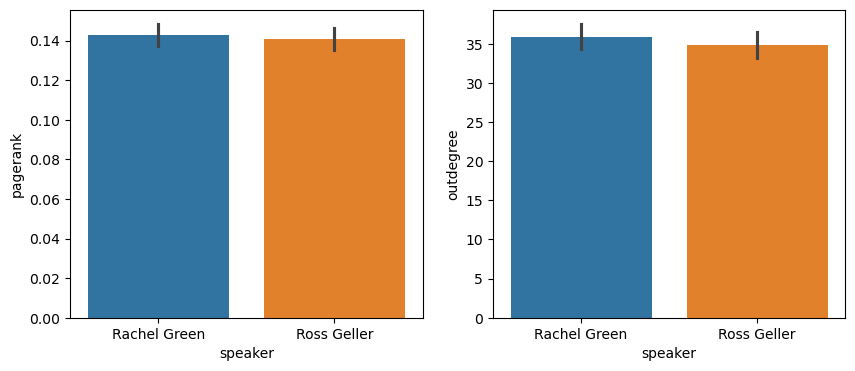

In [278]:
#C
names_toplot = ["Rachel Green", "Ross Geller"]
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.barplot(df_centrality_all_episodes.loc[df_centrality_all_episodes.speaker.isin(names_toplot)], x="speaker", y="pagerank", errorbar=('ci', 95), hue="speaker", ax=axes[0])
sns.barplot(df_centrality_all_episodes.loc[df_centrality_all_episodes.speaker.isin(names_toplot)], x="speaker", y="outdegree", errorbar=('ci', 95), hue="speaker", ax=axes[1])
plt.show()

#D No the plots does not support the hypothesis that Rachel was the show's protagonist as the 95% confidence overlap for both metrics. So, we can no longer conclude on our previous conclusion made on Rachel.

---

**1.7 —** **/True or false:/** Considering your answer in **1.6** are the following statements true or false? Justify your answer. 


A. "In season 7, Rachel Green's episode-level PageRank and out-degree centrality are higher than Ross Geller's. This difference is statistically significant at the 0.05 significance level."

B. "Phoebe Buffay's out-degree grew between season 1 and season 10; this implies that other characters spoke less than her in season 10."

C. "Phoebe Buffay's PageRank was higher in season 10 than in season 1. This difference is statistically significant at the 0.05 significance level and suggests that the character gained importance over the course of the show."


In [285]:
#A 
rachel_pagerank_set = df_centrality_all_episodes.loc[(df_centrality_all_episodes.speaker=="Rachel Green")&(df_centrality_all_episodes.season=="s07")].pagerank
rachel_outdegree_set = df_centrality_all_episodes.loc[(df_centrality_all_episodes.speaker=="Rachel Green")&(df_centrality_all_episodes.season=="s07")].outdegree

ross_pagerank_set = df_centrality_all_episodes.loc[(df_centrality_all_episodes.speaker=="Ross Geller")&(df_centrality_all_episodes.season=="s07")].pagerank
ross_outdegree_set = df_centrality_all_episodes.loc[(df_centrality_all_episodes.speaker=="Ross Geller")&(df_centrality_all_episodes.season=="s07")].outdegree

from scipy.stats import ttest_ind

print(ttest_ind(rachel_pagerank_set, ross_pagerank_set))
print(ttest_ind(rachel_outdegree_set, ross_outdegree_set))

print("\nTRUE, after having done Ttest on pagerank and outdegree results, both have their pagerank under the 0.05 significance level")

TtestResult(statistic=3.354896379999326, pvalue=0.0015983861574955138, df=46.0)
TtestResult(statistic=3.629929005595827, pvalue=0.0007096026211023994, df=46.0)

TRUE, after having done Ttest on pagerank and outdegree results, both have their pagerank under the 0.05 significance level


#B FALSE, this does not imply. Rachel speak more (more outgoing degree) but we can not conclude from this knowledge on other character speaking time.

In [293]:
#B
phoebe_s01 = df_centrality_all_episodes.loc[(df_centrality_all_episodes.speaker=="Phoebe Buffay")&(df_centrality_all_episodes.season=="s01")].pagerank
phoebe_s10 = df_centrality_all_episodes.loc[(df_centrality_all_episodes.speaker=="Phoebe Buffay")&(df_centrality_all_episodes.season=="s10")].pagerank

print(ttest_ind(phoebe_s01, phoebe_s10))
print("\nTrue, after having done Ttest on pagerank, the p_value is 0.039<0.05 so the 0.05 significance level is achieved. Yes, as the pagerank increases, it means Phoebe importance raises between season 1 and 10.")

TtestResult(statistic=-2.1258488247047795, pvalue=0.039739577553817566, df=40.0)

True, after having done Ttest on pagerank, the p_value is 0.039<0.05 so the 0.05 significance level is achieved. Yes, as the pagerank increases, it means Phoebe importance raises between season 1 and 10.


## Part 2: The one about text similarity (40 pts)

Next, you investigate how unique characters are by analyzing what they said throughout the 10 seasons.

**2.1 —** Load the dataframe `exam3.jsonl`. This dataframe is similar to `exam1.jsonl`, except:

- It has an additional column called `tokens`, containing a sentence list. Each sentence is another list composed of tokens, e.g.,
`[['There', "'s", 'nothing', 'to', 'tell', '!'], ['He', "'s", 'just', 'some', 'guy', 'I', 'work', 'with', '!']]`.
- It has an additional column called `episode` containing a unique episode identifier.
- It only contains utterances by Phoebe, Rachel, Ross, Joey, Monica, or Chandler (the main characters).
 
Given this dataframe, you will create an episode-level word-frequency matrix for Chandler Bing, one of the main characters.

A. Create a list $L$ containing all distinct tokens uttered by Chandler Bing throughout the 10 seasons, sorted in ascending order. Print the 10 first and last elements of the list. 

B. Create a matrix $X$ with $m$ rows and $n$ columns, where: $n$ is the number of tokens in the list $L$ that you just created, and $m$ is the number of episodes (236). Each position $X_{i,j}$ in this matrix should contain the number of times the character uttered the word $j$ in episode $i$. Print how many times Chandler uttered the token `joey` in the first episode of the first season, as well as the shape of the matrix $X$.

C. Transform the matrix $X$ into a TF-IDF matrix $T$, combining the following formula (as seen in class):

$$\text{TF}(i,j) = \text{number of times the $j$-th word occurs in the $i$-th episode}$$

$$\text{IDF}(j) =  \log \frac{\text{number of episodes}}{\text{number of episodes in which the $j$-th word occurs}}$$

Print the value in the TF-IDF matrix corresponding to Chandler's utterance of the token `joey` in the first episode of the first season.

D. **/Discuss:/** Some of the tokens (e.g., `joey`) reference other characters. How may these tokens help a classifier predict which character uttered a sentence?

In [314]:
#A
df_part2 = pd.read_json(path_or_buf="data/exam3.jsonl", lines=True)

In [342]:
L_chandler_df = df_part2.loc[df_part2.speaker=="Chandler Bing"]
L_chandler_df.tokens = L_chandler_df.tokens.astype(str)

C:\Users\paul\AppData\Local\Temp/ipykernel_30692/2323383.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  L_chandler_df.tokens = L_chandler_df.tokens.astype(str)


In [343]:
import codecs
import spacy
import os
from collections import Counter

nlp = spacy.load('en_core_web_sm')

In [ ]:
df_part2["tokenized"] = df_part2["tokens"].apply(lambda x: nlp.tokenizer(x))

In [ ]:
books = []
words = []
for k,v in L_chandler_df.iterrows():
    books.append([" ".join(b.split()) for b in v.astype(str)])
    doc = nlp(str(books[k]))
    words.append([token.text for token in doc if token.is_punct != True])

In [ ]:
#B

---
For the remainder of the task, you will use the TF-IDF matrix that we compute below. Note:
- This matrix was calculated in a slightly different way: it considers only the 1000 tokens with the highest term frequency.
- We provide three useful variables below (`X`, `y`, and `df_tfidf`). 
    - `X` is a matrix containing the TF-IDF values for the top 1000 tokens, where each row corresponds to a character in an episode. 
    - `y` indicates which character is responsible for the utterance. Each character has a corresponding number, e.g., 2 for Monica Geller; see dictionary below. 
    - `df_tfidf` is a dataframe combining `X` with other episode and utterance-level metadata.

In [363]:
from sklearn.feature_extraction.text import TfidfVectorizer
df_tfidf = pd.read_json("./data/exam3.jsonl", lines=True)[["speaker", "episode", "text"]]

vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
X = vectorizer.fit_transform(df_tfidf.text).toarray()
print("X shape", X.shape)


map_char_to_int = {
'Chandler Bing': 0,
'Joey Tribbiani': 1,
'Monica Geller': 2,
'Phoebe Buffay': 3,
'Rachel Green': 4,
'Ross Geller': 5
}


y = df_tfidf.speaker.apply(lambda x: map_char_to_int[x]).values
print("y shape", y.shape)

df_tfidf = pd.concat([df_tfidf[["speaker", "episode"]],  pd.DataFrame(X)], axis=1)

df_tfidf.head(3)

X shape (51312, 1000)
y shape (51312,)


,speaker,episode,0,1,2,3,4,5,6,7,...,990,991,992,993,994,995,996,997,998,999
0,Monica Geller,s01_e01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Joey Tribbiani,s01_e01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Chandler Bing,s01_e01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


--- 

**2.2 —** To compare characters, carry out a classification task. Train a decision tree classifier to predict which main character uttered a sentence..

A. Split the dataset into training and test sets using sklearn `sklearn.model_selection.train_test_split` using parameters `test_size=0.3` and `random_state=42`, and using the default values for all other parameters.

B. Train a decision tree classifier (`sklearn.tree.DecisionTreeClassifier`) using `random_state=42`, leaving all other parameters as their default.

C. Compute the accuracy of your classifier and of a random baseline, i.e., a classifier that predicts a character uniformly at random. **/Discuss:/** Compare the two accuracies.


D. Compute the confusion matrix of your classifier using `sklearn.metrics.confusion_matrix`. Normalize the confusion matrix such that all cells sum to 1.

E. Plot an appropriate graphical representation of the confusion matrix.

F. **/Discuss:/** Analyzing the confusion matrix, discuss:
   - Which character is most distinct in the way they talk?
   - Which two characters are the most similar in the way they talk?
   - Which two characters are the least similar in the way they talk?


In [364]:
#A
from  sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [365]:
#B
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train,y_train)

In [ ]:
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold=0.5): 
    """Takes outcome of a logistic regression (@prediction_proba), 
    convert it into binary result depending on the chosen @decision_threshold,
    and classify this depending on @true_label"""
    predict_label = (prediction_proba[:,1]>decision_threshold).astype(int)

    TP = np.sum(np.logical_and(predict_label==1, true_label==1))
    TN = np.sum(np.logical_and(predict_label==0, true_label==0))
    FP = np.sum(np.logical_and(predict_label==1, true_label==0))
    FN = np.sum(np.logical_and(predict_label==0, true_label==1))
    
    confusion_matrix = np.asarray([[TP, FP],
                                    [FN, TN]])
    return confusion_matrix




def plot_confusion_matrix(confusion_matrix):
    """Takes the confusion matrix obtained from compute_confusion_matrix
    and return a heatmap with corresponding results."""
    [[TP, FP],[FN, TN]] = confusion_matrix
    label = np.asarray([[f'TP {TP}', f'FP {FP}'],
                        [f'FN {FN}', f'TN {TN}']])
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative'])
    
    return sns.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='')



def compute_all_score(confusion_matrix, t=0.5):
    """Compute each possible score from the confusion matrix with threshold @t"""
    [[TP, FP],[FN, TN]] = confusion_matrix.astype(float)
    
    accuracy =  (TP+TN)/np.sum(confusion_matrix)
    
    precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
    precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan
    
    recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
    recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan

    F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) \
                                    if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) \
                                    if (precision_negative+recall_negative) !=0 else np.nan

    return [t, accuracy, precision_positive, recall_positive, F1_score_positive,
            precision_negative, recall_negative, F1_score_negative]

In [ ]:
#C

In [ ]:
#D


---

**2.3 —** **/Discuss:/** Last, you discuss the results obtained in **2.2** with a friend, who asks you some thought-provoking questions.

A. Your friend proposes that you should create a measure of similarity between two characters in a given episode in a more direct way than what you've done in **2.2**.  Propose (but do not implement) said similarity metric.

B. Your friend also suggests that your analysis might not truly capture how two characters differ. According to her, if people are in the same conversation, they might speak similarly simply because they are in the same social context. Propose (but do not implement) a way of creating a dataset where this confounder does not exist.

C. Last, your friend complains about how you present your (normalized) confusion matrix. According to her, from reading the cells alone, it is unclear if the fraction of occurrences is higher or lower than what a random classifier would yield. Propose (but do not implement) a way of modifying the confusion matrix to address her concern.


---